In [ ]:
#default_exp core

In [ ]:
#export
from fastai2.vision.all import *

`arch_summary` function plays major role while deciding parameter groups for discriminative learning. It gives a brief summary of architecture and is independant of input being passed. Thus we could use this function to assess the correctness of architecture before passing it to learner. We'll briefly explore various vision models from torchvision and [pytorch-image-models](https://github.com/rwightman/pytorch-image-models) to understand the use of `arch_summary`

In [ ]:
try:
  import timm
except ImportError:
  from pip._internal import main as pip
  pip.main(['install','--user','timm'])
  import timm

In [ ]:
#export
def _is_sequential(o): return o.__class__.__name__=='Sequential'
def _is_fn(o): return type(o)==types.FunctionType

def get_module(o,i):
  "Recursively get the module from list of indices"
  if is_listy(i):
    m = get_module(o,i[0])
    if len(i)==1: return m
    return get_module(m,i[1:])
  return o[i] if is_listy(o) else list(o.children())[i]

def arch_summary(arch,idx=None,verbose=False):
  "Short architecture summary, used for holistic understanding and deciding parameter groups"
  model = arch(False) if _is_fn(arch) else arch
  if idx is not None:
    model = get_module(model,idx)
  for i, l in enumerate(model.children()):
      n_layers = len(l if _is_sequential(l) else flatten_model(l))
      print(f'({i:<2}) {l.__class__.__name__:<17}: {n_layers:<4}layers')
      if verbose and l.has_children:
        layers = [x.__class__.__name__ for x in l.children()]
        for il in layers:
          print(" "*5,il)

Let's first quickly go through `XResNet` series offered by `fastai2`

```python
def xresnet18 (pretrained=False, **kwargs): return _xresnet(pretrained, 1, [2, 2,  2, 2], **kwargs)
```


In [ ]:
arch_summary(xresnet18)

(0 ) ConvLayer        : 3   layers
(1 ) ConvLayer        : 3   layers
(2 ) ConvLayer        : 3   layers
(3 ) MaxPool2d        : 1   layers
(4 ) Sequential       : 2   layers
(5 ) Sequential       : 2   layers
(6 ) Sequential       : 2   layers
(7 ) Sequential       : 2   layers
(8 ) AdaptiveAvgPool2d: 1   layers
(9 ) Flatten          : 1   layers
(10) Dropout          : 1   layers
(11) Linear           : 1   layers


Look at the Sequential layers from 4-7 all having two child layers, that's the meaning of `[2,2,2,2]` in the model definition. Let's go deeper and check what are these two children

In [ ]:
arch_summary(xresnet18,verbose=True)

(0 ) ConvLayer        : 3   layers
      Conv2d
      BatchNorm2d
      ReLU
(1 ) ConvLayer        : 3   layers
      Conv2d
      BatchNorm2d
      ReLU
(2 ) ConvLayer        : 3   layers
      Conv2d
      BatchNorm2d
      ReLU
(3 ) MaxPool2d        : 1   layers
(4 ) Sequential       : 2   layers
      ResBlock
      ResBlock
(5 ) Sequential       : 2   layers
      ResBlock
      ResBlock
(6 ) Sequential       : 2   layers
      ResBlock
      ResBlock
(7 ) Sequential       : 2   layers
      ResBlock
      ResBlock
(8 ) AdaptiveAvgPool2d: 1   layers
(9 ) Flatten          : 1   layers
(10) Dropout          : 1   layers
(11) Linear           : 1   layers


hmm... those are indeed `ResBlocks`, but what is `ResBlock`?

In [ ]:
arch_summary(xresnet18,[4,0],verbose=True)

(0 ) Sequential       : 2   layers
      ConvLayer
      ConvLayer
(1 ) Sequential       : 0   layers
(2 ) ReLU             : 1   layers


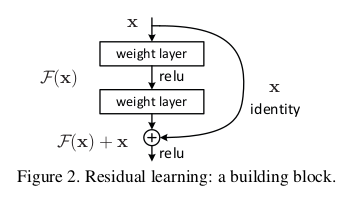

According to [ResNet](https://arxiv.org/abs/1512.03385), we should have two weight layers, an identity (skip-connection) block and activation (ReLU), which is exactly `ResBlock` implements, with many [tweaks](https://arxiv.org/abs/1812.01187) introduced in the following years to improve the performance. A `ConvLayer` in fastai is Conv2D --> BatchNorm --> activation (ReLU). We'll have exact same architecture but with more "groups" of `ResBlock`, such as
```python
def xresnet34 (pretrained=False, **kwargs): return _xresnet(pretrained, 1, [3, 4,  6, 3], **kwargs)
def xresnet50 (pretrained=False, **kwargs): return _xresnet(pretrained, 4, [3, 4,  6, 3], **kwargs)
def xresnet101(pretrained=False, **kwargs): return _xresnet(pretrained, 4, [3, 4, 23, 3], **kwargs)
def xresnet152(pretrained=False, **kwargs): return _xresnet(pretrained, 4, [3, 8, 36, 3], **kwargs)
```

`xresnet34` will have 4 groups having `[3, 4, 6, 3]` no. of `ResBlocks` and so on. We do get other variants of these base architecutures but as they're still experimental, I'll skip them for now. Now let's have a look at some architectures from torchvision.